# fixed pts Gauss bases

### linked if $r \leq radius$

In [34]:
import torch
import math
from torch_cluster import radius
import matplotlib.pyplot as plt

def uniform_points(range_pts,num_pts,dim):
    a = round(math.pow(num_pts, 1 / dim))
    index_tensors = []
    for k in range(dim):
        xmin,xmax = range_pts[k][0],range_pts[k][1]
        idx = xmin + (xmax-xmin)*torch.arange(a).float().add(0.5).div(a)
        idx = idx.view((1,) * k+ (-1,) + (1,) * (dim - k - 1))
        index_tensors.append(idx.expand(a, *([a] * (dim - 1))))
    num_pts1 = int(torch.pow(torch.tensor(a),dim))
    x = torch.stack(index_tensors, dim=dim).reshape(num_pts1,dim)
    return x

N = 10
M = 5
bsz = 10
A = torch.linspace(0,1,N).unsqueeze(-1)
A = A.unsqueeze(0).repeat(bsz,1,1).reshape(-1,A.shape[-1])

B = uniform_points([[0,1]],M,1)

r = 0.2
max_num_neighbors = bsz*(int(2*r*N)+1)
edge_B, edge_A = radius(A , B , r = r,  max_num_neighbors = max_num_neighbors)
print(edge_A.shape)
print(edge_B.shape)
# print(edge_A)
# print(edge_B)


# A_2d = torch.stack((A, torch.zeros(N)), dim=1)  # Shape: (N, 2)
# B_2d = torch.stack((B, torch.ones(M) * 0.1), dim=1)  # Shape: (M, 2)

# plt.figure(figsize=(8, 6))
# plt.scatter(A_2d[:, 0].cpu().numpy(), A_2d[:, 1].cpu().numpy(), color='blue', label='Set A')
# plt.scatter(B_2d[:, 0].cpu().numpy(), B_2d[:, 1].cpu().numpy(), color='red', label='Set B')
# for i, j in zip(col, row):
#     plt.plot([A_2d[i, 0].item(), B_2d[j, 0].item()], [A_2d[i, 1].item(), B_2d[j, 1].item()], color='gray', linestyle='--', alpha=0.5)

# plt.xlim(-0.1, 1.1)
# plt.ylim(-0.1, 0.2)
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.title('Visualization of Edges Between Sets A and B with Separated Y-values')
# plt.legend()
# plt.grid(True)
# plt.show()


torch.Size([180])
torch.Size([180])


### link k nerborhoods

torch.Size([5120, 1])
torch.Size([200, 1])
torch.Size([10, 20, 40]) torch.Size([10, 20, 40])


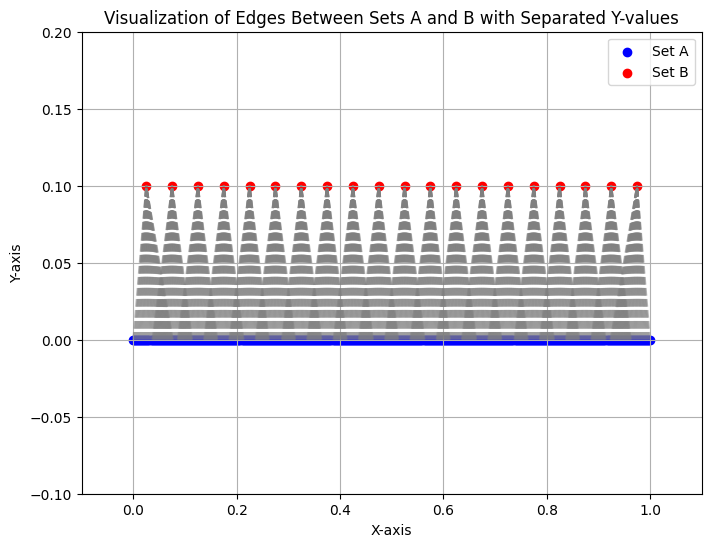

In [86]:
import torch
import math
from torch_cluster import knn
import matplotlib.pyplot as plt

def uniform_points(range_pts,num_pts,dim):
    a = round(math.pow(num_pts, 1 / dim))
    index_tensors = []
    for k in range(dim):
        xmin,xmax = range_pts[k][0],range_pts[k][1]
        idx = xmin + (xmax-xmin)*torch.arange(a).float().add(0.5).div(a)
        idx = idx.view((1,) * k+ (-1,) + (1,) * (dim - k - 1))
        index_tensors.append(idx.expand(a, *([a] * (dim - 1))))
    num_pts1 = int(torch.pow(torch.tensor(a),dim))
    x = torch.stack(index_tensors, dim=dim).reshape(num_pts1,dim)
    return x

N = 512
M = 20
bsz = 10
A = torch.linspace(0,1,N).unsqueeze(-1)
A = A.unsqueeze(0).repeat(bsz,1,1).reshape(-1,A.shape[-1])
print(A.shape)
B = uniform_points([[0,1]],M,1)
B = B.reshape(1,M,1).repeat(bsz,1,1).reshape(-1,B.shape[-1])
print(B.shape)
batch_x = torch.arange(bsz).reshape(bsz,1,1).repeat(1,N,1).reshape(-1)
batch_y = torch.arange(bsz).reshape(bsz,1,1).repeat(1,M,1).reshape(-1)
k = 40

edge_B, edge_A  = knn(A , B ,batch_x = batch_x , batch_y = batch_y, k = k, batch_size=bsz)

edge_A = edge_A.reshape(bsz,M,k)
edge_B = edge_B.reshape(bsz,M,k)

batch_start_indices_A = torch.arange(bsz) * N  # Shape: (bsz,)
edge_A = edge_A - batch_start_indices_A.reshape(*batch_start_indices_A.shape, 1, 1)  # Shape: (bsz, m, k)
batch_start_indices_B = torch.arange(bsz) * M  # Shape: (bsz,)
edge_B = edge_B - batch_start_indices_B.reshape(*batch_start_indices_B.shape, 1, 1)  # Shape: (bsz, m, k)
print(edge_A.shape,edge_B.shape)


A_2d = torch.stack((A.reshape(bsz,N,1)[0,:,0], torch.zeros(N)), dim=1)  # Shape: (N, 2)
B_2d = torch.stack((B.reshape(bsz,M,1)[0,:,0], torch.ones(M) * 0.1), dim=1)  # Shape: (M, 2)

plt.figure(figsize=(8, 6))
plt.scatter(A_2d[:, 0].cpu().numpy(), A_2d[:, 1].cpu().numpy(), color='blue', label='Set A')
plt.scatter(B_2d[:, 0].cpu().numpy(), B_2d[:, 1].cpu().numpy(), color='red', label='Set B')
for i, j in zip(edge_A[0].reshape(-1), edge_B[0].reshape(-1)):
# for i, j in zip(edge_A[0,-1], edge_B[0,-1]):
    plt.plot([A_2d[i, 0].item(), B_2d[j, 0].item()], [A_2d[i, 1].item(), B_2d[j, 1].item()], color='gray', linestyle='--', alpha=0.5)

plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.2)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Visualization of Edges Between Sets A and B with Separated Y-values')
plt.legend()
plt.grid(True)
plt.show()


# value to features

In [6]:
import torch
import math
from torch_cluster import knn
from torch_scatter import scatter
def value2features(x,grid,grid_weight,basepts,baseweight,edge_grid,edge_Gauss):
    '''
    x:                          (bsz, N, in_channel)

    grid:                       (bsz, N, phy_dim)

    grid_weight:                (bsz, N)

    basepts:                    (num_pts, phy_dim)

    baseweight:                 (num_pts, phy_dim)

    edge_grid, edge_Gauss:          (bsz, num_pts, k)

    out:                        (bsz, num_pts, in_channel)
    '''

    bsz,N,phy_dim = grid.shape
    num_pts = basepts.shape[0]
    in_channels = x.shape[-1]
    k = edge_grid.shape[-1]


    grid = grid.reshape(-1,phy_dim)   # bsz*N, phy_dim
    grid_weight = grid_weight.reshape(-1)  # bsz*N

    #### shift value of edge_grid from {0,1,...,N-1} to {0,1,...,bsz*N-1}
    edge_grid = edge_grid.permute(0,2,1) + torch.arange(bsz,device = x.device).unsqueeze(-1).unsqueeze(-1)*N  # bsz, k, num_pts
    edge_grid = edge_grid.reshape(-1)  # bsz*k*num_pts

    ### compute Gauss on each dege
    edge_Gauss = edge_Gauss.permute(0,2,1).reshape(-1)
    dist_square = (grid[edge_grid] - basepts[edge_Gauss])**2   # bsz*k*num_pts, phy_dim

    dist_square = dist_square.reshape(-1,num_pts,phy_dim)  # bsz*k, num_pts, phy_dim
    dist_weighted = torch.sum(baseweight.unsqueeze(0)*dist_square,dim = -1)     # bsz*k, num_pts
    dist_weighted = dist_weighted.reshape(-1).unsqueeze(-1).repeat(1,in_channels)  # bsz*k*num_pts, in_channels
    baseweight = baseweight.unsqueeze(0).unsqueeze(0).repeat(bsz,k,1,1).reshape(-1,phy_dim)   # bsz*k*num_pts, phy_dim
    Gauss_edge = torch.sqrt(torch.prod(baseweight/torch.pi, dim=-1, keepdim=True))*torch.exp(-dist_weighted)  # bsz*k*num_pts, in_channels

    ### compute value on each edge
    gridweight_edge = grid_weight[edge_grid]  # bsz*k*num_pts
    x_edge = x.reshape(-1, in_channels)[edge_grid]  # bsz*k*num_pts,in_channels


    value_edge = Gauss_edge * x_edge * gridweight_edge.unsqueeze(-1)

    #### shift value of edge_Gauss from {0,1,...,M-1} to {0,1,...,bsz*M-1}
    edge_Gauss = edge_Gauss.reshape(bsz,k,num_pts) + torch.arange(bsz,device = x.device).unsqueeze(-1).unsqueeze(-1)*num_pts  # bsz, k, num_pts
    edge_Gauss = edge_Gauss.reshape(-1)

    ### sum
    x_hat = scatter(value_edge, edge_Gauss, dim=0)
    x_hat = x_hat.reshape(bsz,num_pts,-1)
    return x_hat

def compute_edge(grid,basepts,k):
    '''
    grid:        (bsz, N, phy_dim)

    basepts:      (num_pts, phy_dim)

    out(edge_grid,edge_Gauss):       (bsz, num_pts, k)
    '''
    M, phy_dim = basepts.shape
    bsz, N, _ = grid.shape
    grid = grid.reshape(-1,phy_dim)
    basepts = basepts.reshape(1,M,1).repeat(bsz,1,1).reshape(-1,phy_dim)   #bsz*M, phy_dim
    batch_x = torch.arange(bsz).reshape(bsz,1,1).repeat(1,N,1).reshape(-1)
    batch_y = torch.arange(bsz).reshape(bsz,1,1).repeat(1,M,1).reshape(-1)
    edge_Gauss, edge_grid  = knn(grid , basepts ,batch_x = batch_x , batch_y = batch_y, k = k, batch_size=bsz)

    edge_grid = edge_grid.reshape(bsz,M,k)
    edge_Gauss = edge_Gauss.reshape(bsz,M,k)

    edge_grid = edge_grid - (torch.arange(bsz) * N).reshape(bsz, 1, 1)  # Shape: (bsz, M, k)
    edge_Gauss = edge_Gauss - (torch.arange(bsz) * M).reshape(bsz, 1, 1)  # Shape: (bsz, M, k)
    return edge_grid, edge_Gauss

def uniform_points(range_pts,num_pts,dim):
    a = round(math.pow(num_pts, 1 / dim))
    index_tensors = []
    for k in range(dim):
        xmin,xmax = range_pts[k][0],range_pts[k][1]
        idx = xmin + (xmax-xmin)*torch.arange(a).float().add(0.5).div(a)
        idx = idx.view((1,) * k+ (-1,) + (1,) * (dim - k - 1))
        index_tensors.append(idx.expand(a, *([a] * (dim - 1))))
    num_pts1 = int(torch.pow(torch.tensor(a),dim))
    x = torch.stack(index_tensors, dim=dim).reshape(num_pts1,dim)
    return x
N = 512
M = 30
k = 31
bsz = 20
in_channel = 128
basepts = uniform_points([[0,1]],M,1)
base_weight = 100*torch.ones(M,1)
grid = torch.linspace(0,1,N).unsqueeze(-1)
grid = grid.unsqueeze(0).repeat(bsz,1,1)
grid_weight = 1/N*torch.ones(bsz,N)

x = torch.ones(bsz,N,in_channel)
edge_grid, edge_Gauss = compute_edge(grid,basepts,k)
y = value2features(x,grid,grid_weight,basepts,base_weight,edge_grid,edge_Gauss)


tensor([0.3264, 0.3314, 0.3314, 0.3314, 0.3314, 0.3314, 0.3314, 0.3314, 0.3314,
        0.3314, 0.3314, 0.3314, 0.3314, 0.3314, 0.3314, 0.3314, 0.3314, 0.3314,
        0.3314, 0.3314, 0.3314, 0.3314, 0.3314, 0.3314, 0.3314, 0.3314, 0.3314,
        0.3314, 0.3314, 0.3264])


# features to value

In [ ]:
import torch
import math
from torch_cluster import knn
from torch_scatter import scatter
def features2value(x_hat,grid,basepts,baseweight,edge_grid,edge_Gauss):
    '''
    x:                          (bsz, N, in_channel)

    grid:                       (bsz, N, phy_dim)

    grid_weight:                (bsz, N)

    basepts:                    (num_pts, phy_dim)

    baseweight:                 (num_pts, phy_dim)

    edge_grid, edge_Gauss:          (bsz, num_pts, k)

    out:                        (bsz, num_pts, in_channel)
    '''

    bsz,N,phy_dim = grid.shape
    num_pts = basepts.shape[0]
    in_channels = x.shape[-1]
    k = edge_grid.shape[-1]


    grid = grid.reshape(-1,phy_dim)   # bsz*N, phy_dim

    #### shift value of edge_grid from {0,1,...,N-1} to {0,1,...,bsz*N-1}
    edge_grid = edge_grid.permute(0,2,1) + torch.arange(bsz,device = x.device).unsqueeze(-1).unsqueeze(-1)*N  # bsz, k, num_pts
    edge_grid = edge_grid.reshape(-1)  # bsz*k*num_pts

    ### compute Gauss on each dege
    edge_Gauss = edge_Gauss.permute(0,2,1).reshape(-1)
    dist_square = (grid[edge_grid] - basepts[edge_Gauss])**2   # bsz*k*num_pts, phy_dim

    dist_square = dist_square.reshape(-1,num_pts,phy_dim)  # bsz*k, num_pts, phy_dim
    dist_weighted = torch.sum(baseweight.unsqueeze(0)*dist_square,dim = -1)     # bsz*k, num_pts
    dist_weighted = dist_weighted.reshape(-1).unsqueeze(-1).repeat(1,in_channels)  # bsz*k*num_pts, in_channels
    baseweight = baseweight.unsqueeze(0).unsqueeze(0).repeat(bsz,k,1,1).reshape(-1,phy_dim)   # bsz*k*num_pts, phy_dim
    Gauss_edge = torch.sqrt(torch.prod(baseweight/torch.pi, dim=-1, keepdim=True))*torch.exp(-dist_weighted)  # bsz*k*num_pts, in_channels


    #### shift value of edge_Gauss from {0,1,...,M-1} to {0,1,...,bsz*M-1}
    edge_Gauss = edge_Gauss.reshape(bsz,k,num_pts) + torch.arange(bsz,device = x.device).unsqueeze(-1).unsqueeze(-1)*num_pts  # bsz, k, num_pts
    edge_Gauss = edge_Gauss.reshape(-1)


    ### compute value on each edge
    x_hat_edge = x_hat.reshape(-1, in_channels)[edge_Gauss]  # bsz*k*num_pts,in_channels
    value_edge = Gauss_edge * x_hat_edge

    ### sum
    x = scatter(value_edge, edge_grid, dim=0)
    x = x.reshape(bsz,N,-1)
    return x

# 耗时比较

In [6]:
from timeit import default_timer
import torch
import math
from torch_cluster import knn
from torch_scatter import scatter
def value2features(x,grid,grid_weight,basepts,baseweight,edge_grid,edge_Gauss):
    '''
    x:                          (bsz, N, in_channel)

    grid:                       (bsz, N, phy_dim)

    grid_weight:                (bsz, N)

    basepts:                    (num_pts, phy_dim)

    baseweight:                 (num_pts, phy_dim)

    edge_grid, edge_Gauss:          (bsz, num_pts, k)

    out:                        (bsz, num_pts, in_channel)
    '''

    bsz,N,phy_dim = grid.shape
    num_pts = basepts.shape[0]
    in_channels = x.shape[-1]
    k = edge_grid.shape[-1]


    grid = grid.reshape(-1,phy_dim)   # bsz*N, phy_dim
    grid_weight = grid_weight.reshape(-1)  # bsz*N

    #### shift value of edge_grid from {0,1,...,N-1} to {0,1,...,bsz*N-1}
    edge_grid = edge_grid.permute(0,2,1) + torch.arange(bsz,device = x.device).unsqueeze(-1).unsqueeze(-1)*N  # bsz, k, num_pts
    edge_grid = edge_grid.reshape(-1)  # bsz*k*num_pts

    ### compute Gauss on each dege
    edge_Gauss = edge_Gauss.permute(0,2,1).reshape(-1)
    dist_square = (grid[edge_grid] - basepts[edge_Gauss])**2   # bsz*k*num_pts, phy_dim

    dist_square = dist_square.reshape(-1,num_pts,phy_dim)  # bsz*k, num_pts, phy_dim
    dist_weighted = torch.sum(baseweight.unsqueeze(0)*dist_square,dim = -1)     # bsz*k, num_pts
    dist_weighted = dist_weighted.reshape(-1).unsqueeze(-1).repeat(1,in_channels)  # bsz*k*num_pts, in_channels
    baseweight = baseweight.unsqueeze(0).unsqueeze(0).repeat(bsz,k,1,1).reshape(-1,phy_dim)   # bsz*k*num_pts, phy_dim
    Gauss_edge = torch.sqrt(torch.prod(baseweight/torch.pi, dim=-1, keepdim=True))*torch.exp(-dist_weighted)  # bsz*k*num_pts, in_channels

    ### compute value on each edge
    gridweight_edge = grid_weight[edge_grid]  # bsz*k*num_pts
    x_edge = x.reshape(-1, in_channels)[edge_grid]  # bsz*k*num_pts,in_channels


    value_edge = Gauss_edge * x_edge * gridweight_edge.unsqueeze(-1)

    #### shift value of edge_Gauss from {0,1,...,M-1} to {0,1,...,bsz*M-1}
    edge_Gauss = edge_Gauss.reshape(bsz,k,num_pts) + torch.arange(bsz,device = x.device).unsqueeze(-1).unsqueeze(-1)*num_pts  # bsz, k, num_pts
    edge_Gauss = edge_Gauss.reshape(-1)

    ### sum
    x_hat = scatter(value_edge, edge_Gauss, dim=0)
    x_hat = x_hat.reshape(bsz,num_pts,-1)
    return x_hat

def features2value(x_hat,grid,basepts,baseweight,edge_grid,edge_Gauss):
    '''
    x_hat:                      (bsz, num_pts, in_channel)

    grid:                       (bsz, N, phy_dim)

    grid_weight:                (bsz, N)

    basepts:                    (num_pts, phy_dim)

    baseweight:                 (num_pts, phy_dim)

    edge_grid, edge_Gauss:          (bsz, num_pts, k)

    out:                        (bsz, num_pts, in_channel)
    '''

    bsz,N,phy_dim = grid.shape
    num_pts = basepts.shape[0]
    in_channels = x_hat.shape[-1]
    k = edge_grid.shape[-1]


    grid = grid.reshape(-1,phy_dim)   # bsz*N, phy_dim

    #### shift value of edge_grid from {0,1,...,N-1} to {0,1,...,bsz*N-1}
    edge_grid = edge_grid.permute(0,2,1) + torch.arange(bsz,device = x_hat.device).unsqueeze(-1).unsqueeze(-1)*N  # bsz, k, num_pts
    edge_grid = edge_grid.reshape(-1)  # bsz*k*num_pts

    ### compute Gauss on each dege
    edge_Gauss = edge_Gauss.permute(0,2,1).reshape(-1)
    dist_square = (grid[edge_grid] - basepts[edge_Gauss])**2   # bsz*k*num_pts, phy_dim

    dist_square = dist_square.reshape(-1,num_pts,phy_dim)  # bsz*k, num_pts, phy_dim
    dist_weighted = torch.sum(baseweight.unsqueeze(0)*dist_square,dim = -1)     # bsz*k, num_pts
    dist_weighted = dist_weighted.reshape(-1).unsqueeze(-1).repeat(1,in_channels)  # bsz*k*num_pts, in_channels
    baseweight = baseweight.unsqueeze(0).unsqueeze(0).repeat(bsz,k,1,1).reshape(-1,phy_dim)   # bsz*k*num_pts, phy_dim
    Gauss_edge = torch.sqrt(torch.prod(baseweight/torch.pi, dim=-1, keepdim=True))*torch.exp(-dist_weighted)  # bsz*k*num_pts, in_channels


    #### shift value of edge_Gauss from {0,1,...,M-1} to {0,1,...,bsz*M-1}
    edge_Gauss = edge_Gauss.reshape(bsz,k,num_pts) + torch.arange(bsz,device = x_hat.device).unsqueeze(-1).unsqueeze(-1)*num_pts  # bsz, k, num_pts
    edge_Gauss = edge_Gauss.reshape(-1)


    ### compute value on each edge
    x_hat_edge = x_hat.reshape(-1, in_channels)[edge_Gauss]  # bsz*k*num_pts,in_channels
    value_edge = Gauss_edge * x_hat_edge

    ### sum
    x = scatter(value_edge, edge_grid, dim=0)
    x = x.reshape(bsz,N,-1)
    return x

def compute_edge(grid,basepts,k):
    '''
    grid:        (bsz, N, phy_dim)

    basepts:      (num_pts, phy_dim)

    out(edge_grid,edge_Gauss):       (bsz, num_pts, k)
    '''
    M, phy_dim = basepts.shape
    bsz, N, _ = grid.shape
    grid = grid.reshape(-1,phy_dim)
    basepts = basepts.reshape(1,M,1).repeat(bsz,1,1).reshape(-1,phy_dim)   #bsz*M, phy_dim
    batch_x = torch.arange(bsz).reshape(bsz,1,1).repeat(1,N,1).reshape(-1)
    batch_y = torch.arange(bsz).reshape(bsz,1,1).repeat(1,M,1).reshape(-1)
    edge_Gauss, edge_grid  = knn(grid , basepts ,batch_x = batch_x , batch_y = batch_y, k = k, batch_size=bsz)

    edge_grid = edge_grid.reshape(bsz,M,k)
    edge_Gauss = edge_Gauss.reshape(bsz,M,k)

    edge_grid = edge_grid - (torch.arange(bsz) * N).reshape(bsz, 1, 1)  # Shape: (bsz, M, k)
    edge_Gauss = edge_Gauss - (torch.arange(bsz) * M).reshape(bsz, 1, 1)  # Shape: (bsz, M, k)
    return edge_grid, edge_Gauss

def uniform_points(range_pts,num_pts,dim):
    a = round(math.pow(num_pts, 1 / dim))
    index_tensors = []
    for k in range(dim):
        xmin,xmax = range_pts[k][0],range_pts[k][1]
        idx = xmin + (xmax-xmin)*torch.arange(a).float().add(0.5).div(a)
        idx = idx.view((1,) * k+ (-1,) + (1,) * (dim - k - 1))
        index_tensors.append(idx.expand(a, *([a] * (dim - 1))))
    num_pts1 = int(torch.pow(torch.tensor(a),dim))
    x = torch.stack(index_tensors, dim=dim).reshape(num_pts1,dim)
    return x

def compute_bases_Gauss(grid,basepts,baseweight):
    #grid.shape:  bsz,N,phy_dim
    grid = grid.unsqueeze(2) #bsz,N,1,phy_dim
    basepts = basepts.unsqueeze(0).unsqueeze(0) # 1,1,K2,phy_dim
    baseweight = torch.abs(baseweight).unsqueeze(0).unsqueeze(0)  #1,1,K2,phy_dim
    bases = torch.sqrt(torch.prod(baseweight/torch.pi, dim=3))*torch.exp(-1*torch.sum(baseweight*(grid-basepts)**2,dim=3))  #bsz,N,K2,phy_dim-->bsz,N,K2 
    # bases = bases*math.sqrt(bases.shape[1])/torch.norm(bases, p=2, dim=1, keepdim=True)
    return bases

def move(device,*tensor_list):
    return [tensor.to(device) for tensor in tensor_list]

N = 961
M = 400
k = 30
bsz = 1000
in_channel = 32
device = 'cuda'
test_times = 1
basepts = uniform_points([[0,1]],M,1)
base_weight = 1000000*torch.ones(M,1)
grid = torch.sin(torch.linspace(0,1,N)).unsqueeze(-1)
grid = grid.unsqueeze(0).repeat(bsz,1,1)  #bsz,N,phy_dim
grid_weight = 1/N*torch.ones(bsz,N)


x = torch.ones(bsz,N,in_channel)
edge_grid, edge_Gauss = compute_edge(grid,basepts,k)


x,grid,grid_weight,basepts,base_weight,edge_grid,edge_Gauss = move(device,x,grid,grid_weight,basepts,base_weight,edge_grid,edge_Gauss)
bases = compute_bases_Gauss(grid,basepts,base_weight)
wbases = bases * grid_weight.unsqueeze(-1)   #bsz,N,M
torch.cuda.synchronize()
# t1 = default_timer()
# for _ in range(test_times):
#     T1 = default_timer()
#     torch.cuda.synchronize()
#     T2 = default_timer()
#     x_hat1 = torch.einsum('bxi,bxk -> bki',x,wbases)
#     torch.cuda.synchronize()
#     T3 = default_timer()
#     out1 = torch.einsum('bki,bxk -> bxi',x_hat1,bases)
#     torch.cuda.synchronize()
#     T4 = default_timer()
#     print('wbases one time: ',T4-T1, 'compute bases: ',T2-T1, 'value2features: ',T3-T2,'features2value: ',T4-T3 )
# torch.cuda.synchronize()
t2 = default_timer()
for _ in range(test_times):
    T1 = default_timer()
    x_hat2 = value2features(x,grid,grid_weight,basepts,base_weight,edge_grid,edge_Gauss)
    torch.cuda.synchronize()
    T2 = default_timer()
    out2 = features2value(x_hat2,grid,basepts,base_weight,edge_grid,edge_Gauss)
    torch.cuda.synchronize()
    T3 = default_timer()
    print('graph one time: ',T3-T1, 'value2features: ',T2-T1,'features2value: ',T3-T2)
torch.cuda.synchronize()
t3 = default_timer()
# print('wbases time: ',t2-t1)
print('graph time: ',t3-t2)


# print('feature rel L2 loss: ',torch.norm(x_hat1-x_hat2).item()/torch.norm(x_hat1).item())
# print('out rel L2 loss: ',torch.norm(out1-out2).item()/torch.norm(out1).item())/



OutOfMemoryError: CUDA out of memory. Tried to allocate 2.86 GiB. GPU 

### notes
Graph的优势： 在$M\times k = C$时的内存、效率都更高，但不适合于较高的channel个数

在$N = 5120$时：

Graph时间$t_G \approx T_1\times M\times k\times channel\times bsz  (k\times channel较小时)$

wbases时间$t_w \approx T_2\times M\times bsz$

因此$k\times channel $较小时Graph更优

经过测试，当$k\times channel\leq 2000$时Graph更快